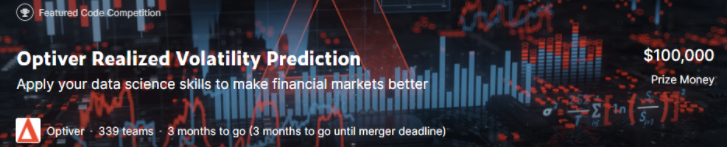

> ## TabNET
> Deep learning model for table data <br>
> A model that takes advantage of Tree-based and DNN <br>
> While having the interpretability of Tree-based (decision tree-based algorithm), it has high performance like DNN for large data sets. <br>
> Unlike the Tree-based model, it does not require any feature generation.

### If you have GPU time,I recommed you to use it.

In [ ]:
!pip install ../input/pytorch-tabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [ ]:
from pathlib import Path
import pandas as pd
import glob
import numpy as np
import pyarrow.parquet
import pyarrow as pa
import seaborn as sns
from sklearn.model_selection import train_test_split
#import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import gc
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test_data = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

train_data =train_data[train_data.stock_id ==0]
display(train_data.head())
display(test_data.head())

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Dedicated function</span>

In [ ]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap
def calc_wap3(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2']+ df['ask_size2'])
    return wap


def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">The process of reading a trade file</span>

In [ ]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

### Please refer to the LightBGM edition for the explanation here.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Pre-processing</span>

In [ ]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap3'] = calc_wap3(df)
    df['log_return3'] = df.groupby('time_id')['wap3'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'log_return3':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }
       # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature    
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature
    

In [ ]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)   
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [ ]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

In [ ]:
data_dir = '../input/optiver-realized-volatility-prediction/'

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;"> Train data create</span>

In [ ]:
train = pd.read_csv(data_dir + 'train.csv')
train.head()

### 🔔4 Operate all with multiplex. (Df = Parallel (n_jobs = 4, verbose = 1) makes 4 multiplexes) Still it takes time.

In [ ]:
train_ids = train.stock_id.unique()
df_train = preprocessor(list_stock_ids=train_ids, is_train = True)
df_train

### Create row_id to merge data

In [ ]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

⌨Make a backup. It's hard to make a mistake and start over.

In [ ]:
df_train_bk = df_train.copy()
#df_train = df_train_bk.copy()

In [ ]:
df_train

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Test data create</span>

In [ ]:
test = pd.read_csv(data_dir + 'test.csv')
test

In [ ]:
df_test_ids = test.stock_id.unique()
df_test = preprocessor(list_stock_ids=df_test_ids, is_train = False)
#df_test['stock_id'] =df_test['row_id'].str.split('-').str[0]
#df_test['time_id'] =df_test['row_id'].str.split('-').str[1]
#df_test =df_test.drop(['row_id'],axis=1)
df_test = test.merge(df_test, on = ['row_id'], how = 'left')
df_test

In [ ]:
from sklearn.model_selection import KFold


df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_ext'] = df_test['stock_id'].map(stock_id_target_mean) # test_set



tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 77)
for idx_1, idx_2 in tqdm(kf.split(df_train)):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_ext'] = tmp

In [ ]:
df_train = df_train.reset_index(drop=True)
target = df_train['target']
df_train = df_train.drop(['target'],axis=1)


X = df_train
y = target

### Make sure that train and test have the same number of columns

In [ ]:
col =['log_return_realized_volatility',
       'log_return2_realized_volatility', 'log_return3_realized_volatility',
       'wap_balance_mean', 'price_spread_mean', 'bid_spread_mean',
       'ask_spread_mean', 'volume_imbalance_mean', 'total_volume_mean',
       'wap_mean', 'log_return_realized_volatility_450',
       'log_return2_realized_volatility_450',
       'log_return3_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap_mean_450',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300',
       'log_return3_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_150',
       'log_return2_realized_volatility_150',
       'log_return3_realized_volatility_150', 'wap_balance_mean_150',
       'price_spread_mean_150', 'bid_spread_mean_150', 'ask_spread_mean_150',
       'volume_imbalance_mean_150', 'total_volume_mean_150', 'wap_mean_150',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300',  'stock_id_target_ext']

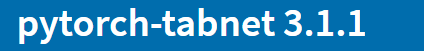

There is a detailed explanation here. As you can see, I use it as it is. <br>
It seems that the parameters can also be changed. For the time being, I will use the initial value <br>

Why did you use that parameter some time ago? Q / A came. it's simple. Because it is an initial parameter. <br>
https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#installation

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">TabNetRegressor</span>

In [ ]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
#X[col] = scaler.fit_transform(X[col])

In [ ]:
X[col] = X[col].fillna(X[col].mean())

In [ ]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [ ]:
%%capture
'''

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=77, shuffle=True)
oof = pd.DataFrame()               
models = []                          
scores = 0.0  


clf = TabNetRegressor() 
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X[col].loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X[col].loc[val_idx], y[val_idx]


    clf.fit(
       X_train.values, y_train.values.reshape(-1,1),
       eval_set=[(X_valid.values, y_valid.values.reshape(-1,1))])
    
    y_pred = clf.predict(X_valid.values)
    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
    
    models.append(clf)
'''

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X[col], y, test_size=0.3, random_state=42)
clf = TabNetRegressor()  #TabNetRegressor()
clf.fit(
  x_train.values, y_train.values.reshape(-1,1),
  eval_set=[(x_valid.values, y_valid.values.reshape(-1,1))])


In [ ]:
preds = clf.predict(x_valid.values)

In [ ]:

#rmspe_score = rmspe(y_valid, preds)
#print(f'RMSPE is {rmspe_score}')

In [ ]:
#preds =[]
#for clf in models
#    preds.append(pred = clf.predict(test))
    

In [ ]:
len(x_train[col].columns)

In [ ]:
len(df_test[col].columns)

In [ ]:
x_train[col].head()

In [ ]:
#df_test[col] = scaler.fit_transform(df_test[col])

In [ ]:
df_test[col] = df_test[col].fillna(df_test[col].mean())

In [ ]:
df_test[col] = df_test[col].fillna(0)

In [ ]:
df_test[col]

In [ ]:
preds = clf.predict(df_test[col].values)

In [ ]:
sub = pd.read_csv('../input/optiver-realized-volatility-prediction/sample_submission.csv')
sub.target = preds.mean()

In [ ]:
sub.to_csv('submission.csv',index=False)
sub

### I'll do the AutoML system later.

😅㊙🔰🗑⬛🟥🟨🟩